<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

<br>
<br>
Clase: Series de tiempo
<br>
Actividad: Regresión Lineal
<br>
<br>

* * *

Docente: Daniel Nuño <br>
Fecha: 23 de septiembre 2024 <br>

* * *

<br>
<br>

# Regresión Lineal

En esta actividad realizaras lo siguiente:

**Creación de variables**

* importar datos (variable exógena, X a la respuesta Y)
* variables de estacionales
* tendencia
* variables de atípicos
* variables rezagos

**Aplicación de regresión lineal múltiple**

**Evaluación de resultados y errores**

**Selección de variables**


> The forecast variable y is sometimes also called the regressand, dependent or explained variable. The predictor variables x are sometimes also called the regressors, independent or explanatory variables.


## Variables X

### Importar datos

Importa la serie de tiempo que escogiste anteriormente para usar como variable que explica a tu variable objetivo.

En el ejemplo de las remeses
- mi variable objetivo son las remeses recibidas cada mes
- mi variable exógena es el tipo de cambio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.optimize as sco
import cvxpy as cp
import datetime

In [4]:
tickers = ['NVDA']

# Descargar datos de precios ajustados al cierre de las acciones seleccionadas
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime.now()
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Adj Close
Date,
2023-01-03,14.305581
2023-01-04,14.739294
2023-01-05,14.255614
2023-01-06,14.849224
2023-01-09,15.617718


In [6]:
stock = 'MXN=X'
ticker = yf.Ticker(stock)
usdmxn = ticker.history(start= '1993-01-01', end= '2023-12-31', interval='1mo')['Close']

usdmxn.head()

,Close
Date,
2003-12-01 00:00:00+00:00,11.191
2004-01-01 00:00:00+00:00,11.048
2004-02-01 00:00:00+00:00,11.055
2004-03-01 00:00:00+00:00,11.105
2004-04-01 00:00:00+01:00,11.352


- Ajusta la serie de tiempo para que las fechas sean las mismas.
- Ajusta el formato de la fecha.

In [7]:
data = data["2003":]

In [8]:
usdmxn = usdmxn["2004":]

In [9]:
usdmxn.index = usdmxn.index.strftime('%Y-%m')
usdmxn.index = pd.to_datetime(usdmxn.index)
usdmxn.head()

,Close
Date,
2004-01-01,11.048
2004-02-01,11.055
2004-03-01,11.105
2004-04-01,11.352
2004-05-01,11.427


In [10]:
data = pd.DataFrame(data.values, columns=['Y'], index=data.index)
data.head()

,Y
Date,
2023-01-03,14.305581
2023-01-04,14.739294
2023-01-05,14.255614
2023-01-06,14.849224
2023-01-09,15.617718


In [11]:
data = data.join(usdmxn)

In [12]:
data.head(24)

,Y,Close
Date,,
2023-01-03,14.305581,NaN
2023-01-04,14.739294,NaN
2023-01-05,14.255614,NaN
2023-01-06,14.849224,NaN
2023-01-09,15.617718,NaN
2023-01-10,15.898532,NaN
2023-01-11,15.990472,NaN
2023-01-12,16.500134,NaN
2023-01-13,16.887882,NaN


### Variables estacionales

En una regresión lineal cómun $$ y =  \beta_1x +  \beta_0 $$

perdemos información relacionada a la estacionalidad, en este caso los meses. Para incluir los meses Enero, Febrero, Marzo, etc. agregamos variable binarias, de tal forma que la ecuación sea $$ y =  \beta_0 +  \beta_{1}x_{enero} +  \beta_{2}x_{febrero} +  \beta_{3}x_{marzo}  \dots $$



In [13]:
getattr(data.index, 'month_name')

<bound method _inherit_from_data.<locals>.method of DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17',
               ...
               '2024-09-12', '2024-09-13', '2024-09-16', '2024-09-17',
               '2024-09-18', '2024-09-19', '2024-09-20', '2024-09-23',
               '2024-09-24', '2024-09-25'],
              dtype='datetime64[ns]', name='Date', length=435, freq=None)>

In [14]:
data['mes'] = data.index.month_name()

In [15]:
data

,Y,Close,mes
Date,,,
2023-01-03,14.305581,NaN,January
2023-01-04,14.739294,NaN,January
2023-01-05,14.255614,NaN,January
2023-01-06,14.849224,NaN,January
2023-01-09,15.617718,NaN,January
...,...,...,...
2024-09-19,117.870003,NaN,September
2024-09-20,116.000000,NaN,September
2024-09-23,116.260002,NaN,September


In [16]:
data = pd.get_dummies(data, columns=['mes'],
                      prefix="", prefix_sep="",
                      drop_first=True, dtype=float)

In [17]:
data

,Y,Close,August,December,February,January,July,June,March,May,November,October,September
Date,,,,,,,,,,,,,
2023-01-03,14.305581,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-04,14.739294,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-05,14.255614,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-06,14.849224,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-09,15.617718,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-19,117.870003,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-09-20,116.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-09-23,116.260002,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Atípicos

De la sesión anterior, utiliza los valores atípicos que encontraste en tu varible. Deben ser una tupla fecha - 1

In [18]:
fecha_2008 = pd.Series(data = [1],
                       index=pd.to_datetime(["2008-11-01"]),
                       name='2008_outlier')
fecha_2020 = pd.Series(data = [1],
                       index=pd.to_datetime(["2020-03-01"]),
                       name='2020_outlier')

In [19]:
fecha_2008

,2008_outlier
2008-11-01,1


In [20]:
data = data.join(fecha_2008).fillna(0)

In [21]:
data["2008":"2008"]

,Y,Close,August,December,February,January,July,June,March,May,November,October,September,2008_outlier
Date,,,,,,,,,,,,,,


In [22]:
data = data.join(fecha_2020).fillna(0)

In [23]:
data["2020":"2020"]

,Y,Close,August,December,February,January,July,June,March,May,November,October,September,2008_outlier,2020_outlier
Date,,,,,,,,,,,,,,,


### Lags

En clases pasadas analizamos la autocorrelación, la cuál nos dice que valores pasados son representativos para el valor actual. Considerando eso y la estacionalidad mensual, puedes crear una 12 variable de rezagos.

$$ y =  \beta_0 +  \beta_{1}x_{mespasado},  \beta_{2}x_{2mesesatras} +  \beta_{3}x_{3mesesatras}  \dots $$

In [24]:
data['lag1'] = data['Y'].shift(1)
data['lag2'] = data['Y'].shift(2)
data['lag3'] = data['Y'].shift(3)
data['lag4'] = data['Y'].shift(4)
data['lag5'] = data['Y'].shift(5)
data['lag6'] = data['Y'].shift(6)
data['lag7'] = data['Y'].shift(7)
data['lag8'] = data['Y'].shift(8)
data['lag9'] = data['Y'].shift(9)
data['lag10'] = data['Y'].shift(10)
data['lag11'] = data['Y'].shift(11)
data['lag12'] = data['Y'].shift(12)

In [25]:
data.head(13)

,Y,Close,August,December,February,January,July,June,March,May,...,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,14.305581,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,14.739294,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05,14.255614,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-06,14.849224,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,14.305581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-09,15.617718,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,14.739294,14.305581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-10,15.898532,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,14.255614,14.739294,14.305581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-11,15.990472,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,14.849224,14.255614,14.739294,14.305581,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-12,16.500134,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,15.617718,14.849224,14.255614,14.739294,14.305581,NaN,NaN,NaN,NaN,NaN
2023-01-13,16.887882,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,15.898532,15.617718,14.849224,14.255614,14.739294,14.305581,NaN,NaN,NaN,NaN


In [26]:
data = data["2004":]

In [27]:
data.shape

(435, 27)

## Aplica el modelo de regresión

In [28]:
import statsmodels.api as sm

In [29]:
?sm.OLS

In [30]:
# Check for infinite values in the dataframe
print(np.isinf(data).any())

# Check for NaNs in the dataframe
print(np.isnan(data).any())

# Replace infinite values with NaNs
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
data.dropna(inplace=True)

# Now try running the regression again
print(sm.OLS(data['Y'], data.drop(columns=['Y'])).fit().summary())

Y               False
Close           False
August          False
December        False
February        False
January         False
July            False
June            False
March           False
May             False
November        False
October         False
September       False
2008_outlier    False
2020_outlier    False
lag1            False
lag2            False
lag3            False
lag4            False
lag5            False
lag6            False
lag7            False
lag8            False
lag9            False
lag10           False
lag11           False
lag12           False
dtype: bool
Y               False
Close           False
August          False
December        False
February        False
January         False
July            False
June            False
March           False
May             False
November        False
October         False
September       False
2008_outlier    False
2020_outlier    False
lag1             True
lag2             True
lag3             Tru

> The Durbin-Watson statistic will always have a value ranging between 0 and 4. A value of 2.0 indicates there is no autocorrelation detected in the sample. Values from 0 to less than 2 point to positive autocorrelation, and values from 2 to 4 mean negative autocorrelation.

> In statistics, the Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution.

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
LinearRegression().fit(data.drop(columns=['Y']),
                       data['Y']).score(data.drop(
                                        columns=['Y']),
                                        data['Y'])

0.9950459962514049

In [33]:
LinearRegression().fit(data.drop(columns=['Y']), data['Y']).coef_

array([ 1.07300797e-03,  2.70420652e-01,  2.85381365e-01,  9.33416615e-01,
        8.70079909e-01, -4.35527687e-02,  9.74435151e-01,  7.19652882e-01,
        1.08358756e+00,  5.47742287e-01,  5.55604613e-02, -7.28165873e-02,
       -1.23512311e-15, -1.49880108e-15,  8.75643744e-01,  1.78799150e-01,
       -9.07548252e-02,  7.24138679e-02, -1.48159509e-01,  9.31866585e-02,
        1.12544510e-02,  2.41937159e-02,  4.45687368e-02, -2.29919943e-01,
        3.82190589e-02,  1.32496951e-01])

In [34]:
LinearRegression().fit(data.drop(columns=['Y']), data['Y']).intercept_

-0.2512960044505874

In [35]:
LinearRegression().fit(data.drop(columns=['Y']), data['Y']).feature_names_in_

array(['Close', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September',
       '2008_outlier', '2020_outlier', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'],
      dtype=object)

In [36]:
LinearRegression().fit(data.drop(columns=['Y']), data['Y']).n_features_in_

26

In [37]:
predict = LinearRegression().fit(data.drop(columns=['Y']),
                                data['Y']).predict(data.drop(
                                            columns=['Y']))

In [38]:
predict[:12]

array([17.45682844, 18.30950594, 19.43786221, 19.78825557, 19.99968713,
       20.26123001, 20.70250374, 19.70723595, 20.05585202, 21.73373754,
       22.24496547, 21.63795957])

In [39]:
errors = LinearRegression().fit(data.drop(columns=['Y']),
                                data['Y']).predict(data.drop(
                                            columns=['Y'])) - data['Y']

In [40]:
errors.head()

,Y
Date,
2023-01-20,-0.370434
2023-01-23,-0.870866
2023-01-24,0.185539
2023-01-25,0.477970
2023-01-26,0.210718


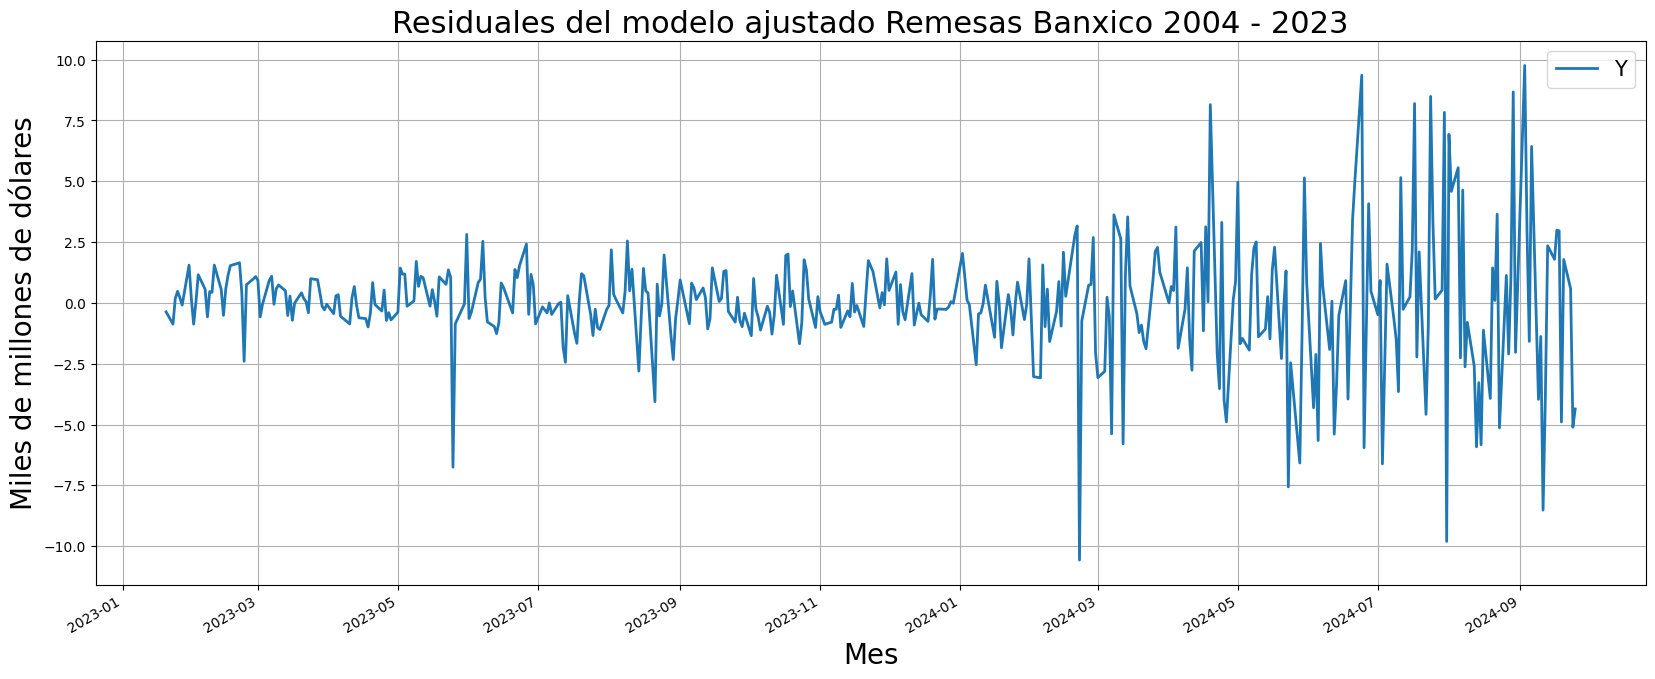

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
errors.plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Residuales del modelo ajustado Remesas Banxico 2004 - 2023', fontsize=22)
ax.set_ylabel('Miles de millones de dólares', fontsize=20)
ax.set_xlabel('Mes', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [42]:
errors.mean()

-1.489956044017042e-14

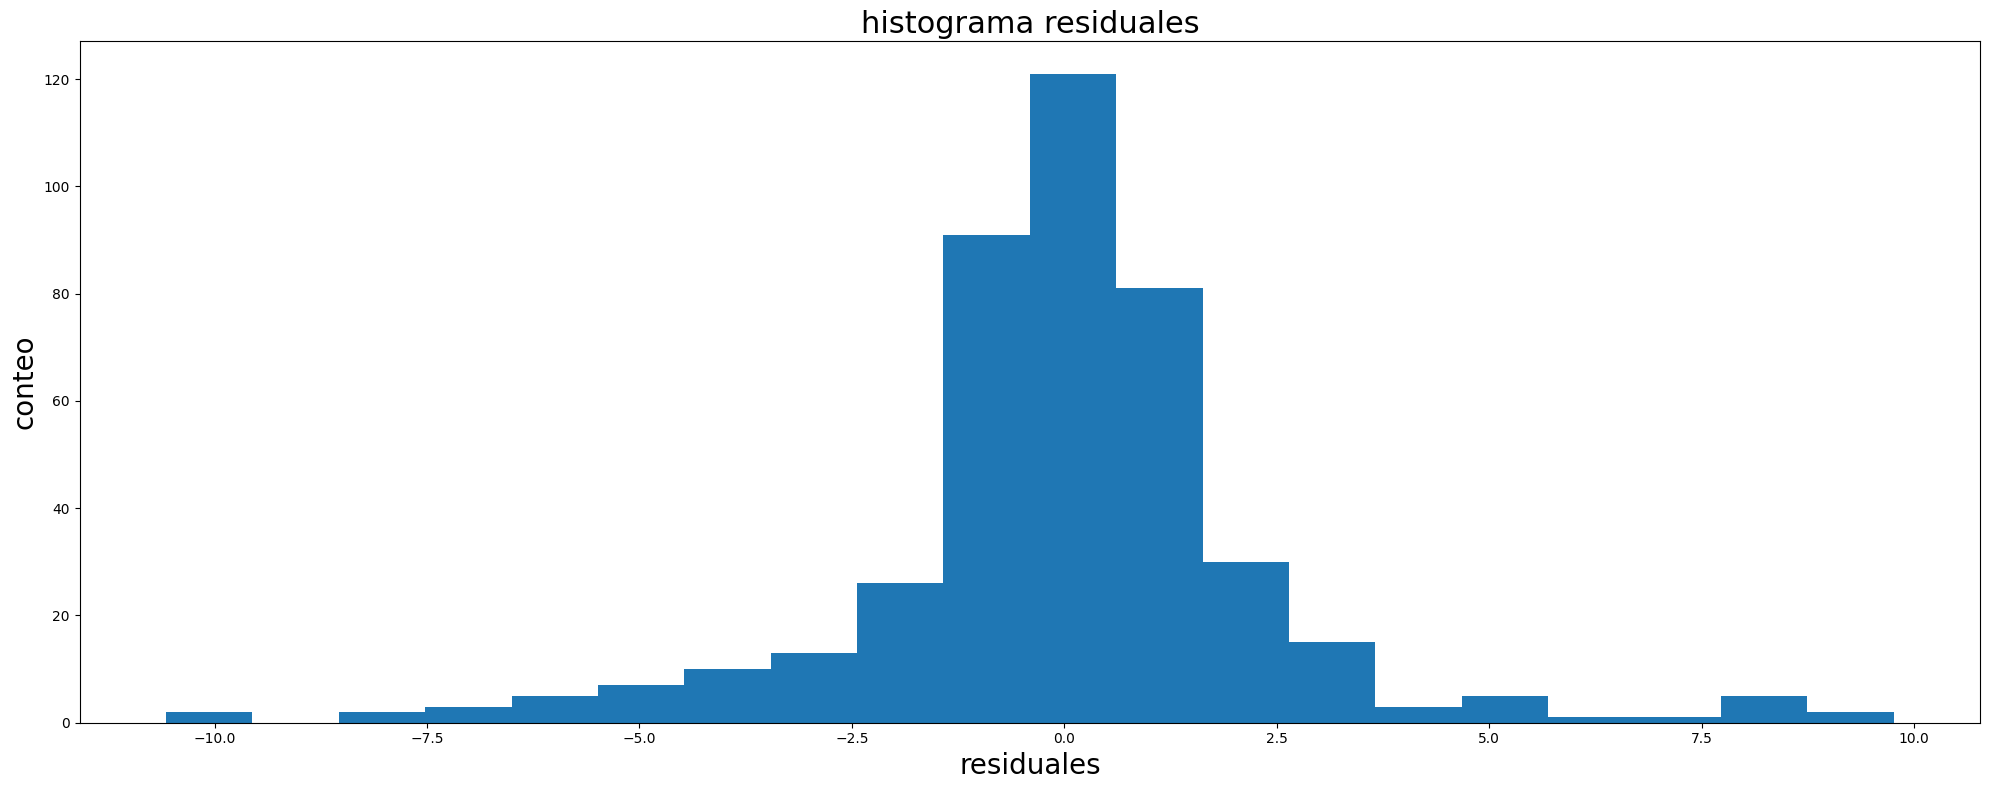

In [43]:
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(20, 8),
                        tight_layout = True)

axs.hist(errors, bins = 20)

# Specify graph features:
axs.set_title('histograma residuales', fontsize=22)
axs.set_ylabel('conteo', fontsize=20)
axs.set_xlabel('residuales', fontsize=20)

# Show plot
plt.show()

Text(0, 0.5, 'ACF')

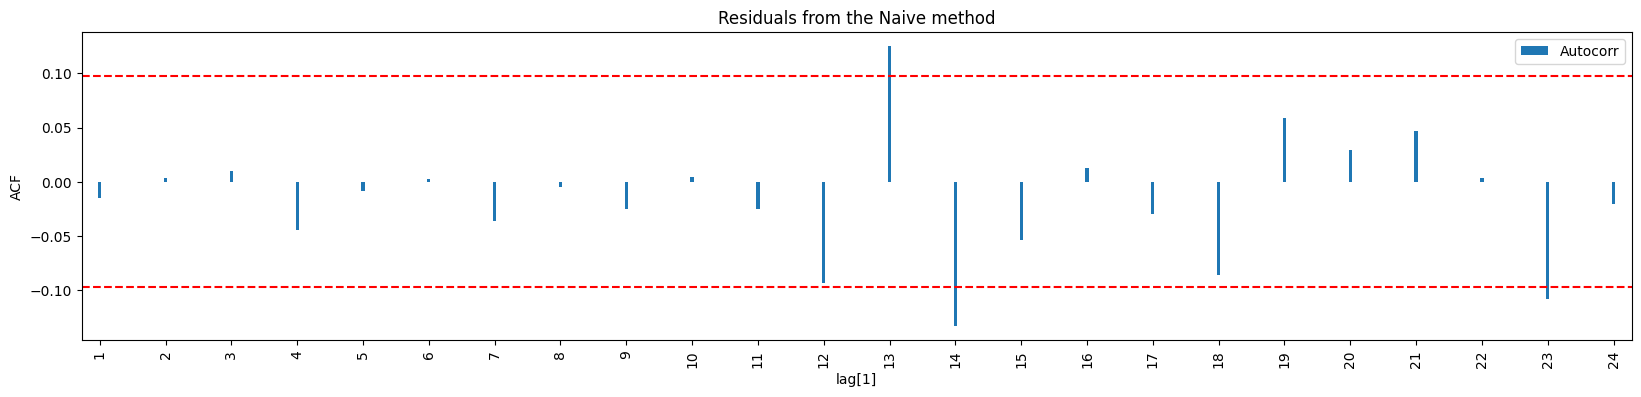

In [44]:
import math

ticker_data = errors
ticker_data_acf = [ticker_data.autocorr(i) for i in range(1,25)]

test_df = pd.DataFrame([ticker_data_acf]).T
test_df.columns = ['Autocorr']
test_df.index += 1
test_df.plot(kind='bar', width = 0.05, figsize = (20, 4))

# Statisfical significance.
n = len(errors)
plt.axhline(y = 2/math.sqrt(n), color = 'r', linestyle = 'dashed')
plt.axhline(y = -2/math.sqrt(n), color = 'r', linestyle = 'dashed')

# Adding plot title.
plt.title("Residuals from the Naive method")

# Providing x-axis name.
plt.xlabel("lag[1]")

# Providing y-axis name.
plt.ylabel("ACF")

### Transformación de variable Y

In [45]:
import scipy as sp

In [46]:
sp.stats.boxcox(data['Y'])[0].shape

(423,)

In [47]:
data_copy = data.copy()
data_copy['Y'] = sp.stats.boxcox(data_copy['Y'])[0]

In [48]:
data_copy.head()

,Y,Close,August,December,February,January,July,June,March,May,...,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-20,2.937372,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,17.690353,16.887882,16.500134,15.990472,15.898532,15.617718,14.849224,14.255614,14.739294,14.305581
2023-01-23,3.013464,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,17.365566,17.690353,16.887882,16.500134,15.990472,15.898532,15.617718,14.849224,14.255614,14.739294
2023-01-24,3.017361,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,16.753969,17.365566,17.690353,16.887882,16.500134,15.990472,15.898532,15.617718,14.849224,14.255614
2023-01-25,3.020489,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,17.827263,16.753969,17.365566,17.690353,16.887882,16.500134,15.990472,15.898532,15.617718,14.849224
2023-01-26,3.045977,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,19.180372,17.827263,16.753969,17.365566,17.690353,16.887882,16.500134,15.990472,15.898532,15.617718


In [49]:
LinearRegression().fit(data_copy.drop(columns=['Y']),
                       data_copy['Y']).score(data_copy.drop(
                                        columns=['Y']),
                                        data_copy['Y'])

0.949039539035577

In [50]:
predict = LinearRegression().fit(data_copy.drop(columns=['Y']),
                                data_copy['Y']).predict(data_copy.drop(
                                            columns=['Y']))

In [51]:
errors = predict - data_copy['Y']

In [52]:
from scipy.special import inv_boxcox

In [53]:
lambda_val = sp.stats.boxcox(data['Y'])[1]

In [54]:
inverted_predictions = inv_boxcox(predict, lambda_val)

In [55]:
inverted_predictions[:12]

array([26.42070112, 26.78028028, 27.34177558, 27.47234091, 27.50221416,
       27.62957017, 27.87975668, 27.45044644, 25.20661224, 26.66987568,
       26.91351722, 26.69941671])

In [56]:
errors = inverted_predictions - data['Y']

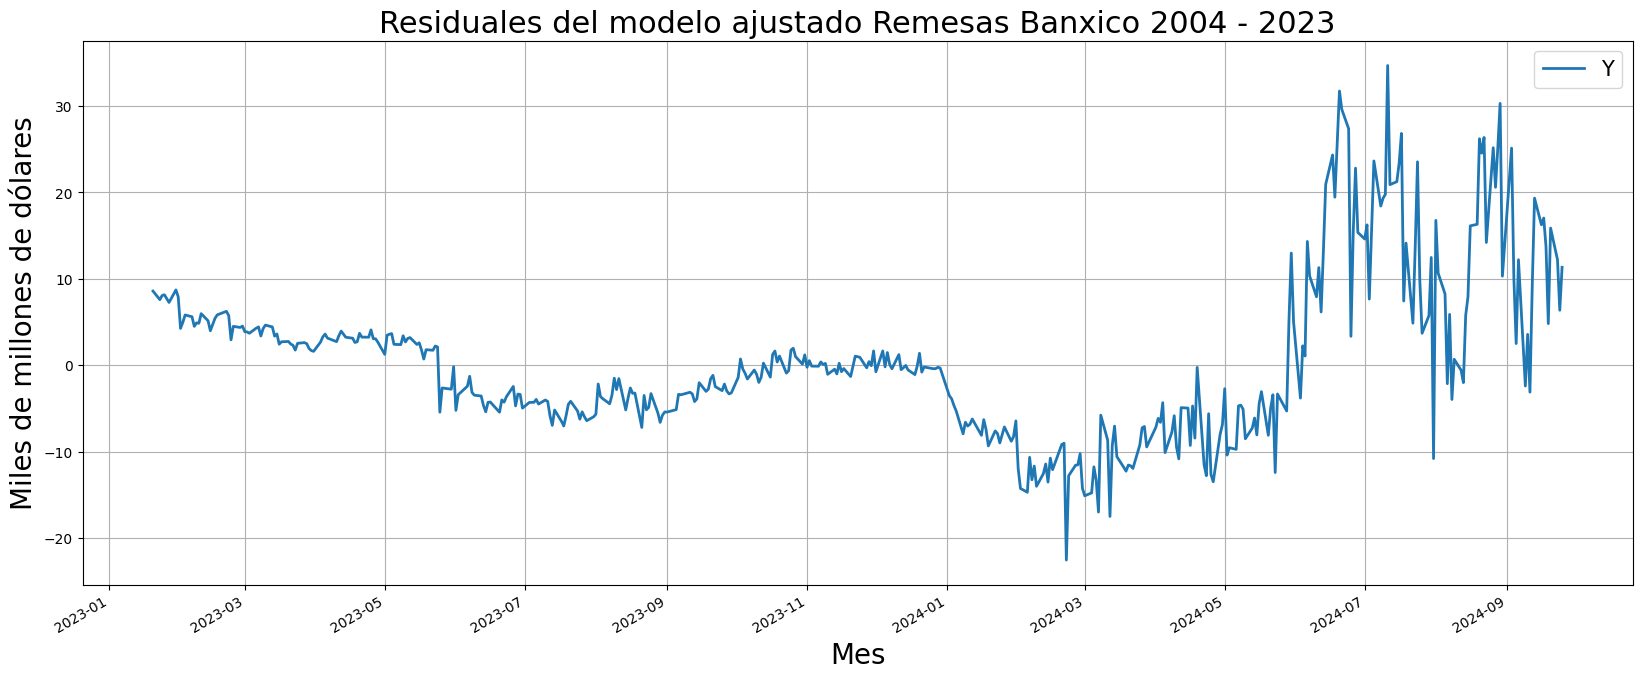

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
errors.plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Residuales del modelo ajustado Remesas Banxico 2004 - 2023', fontsize=22)
ax.set_ylabel('Miles de millones de dólares', fontsize=20)
ax.set_xlabel('Mes', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [58]:
errors.mean()

0.36262503205050944

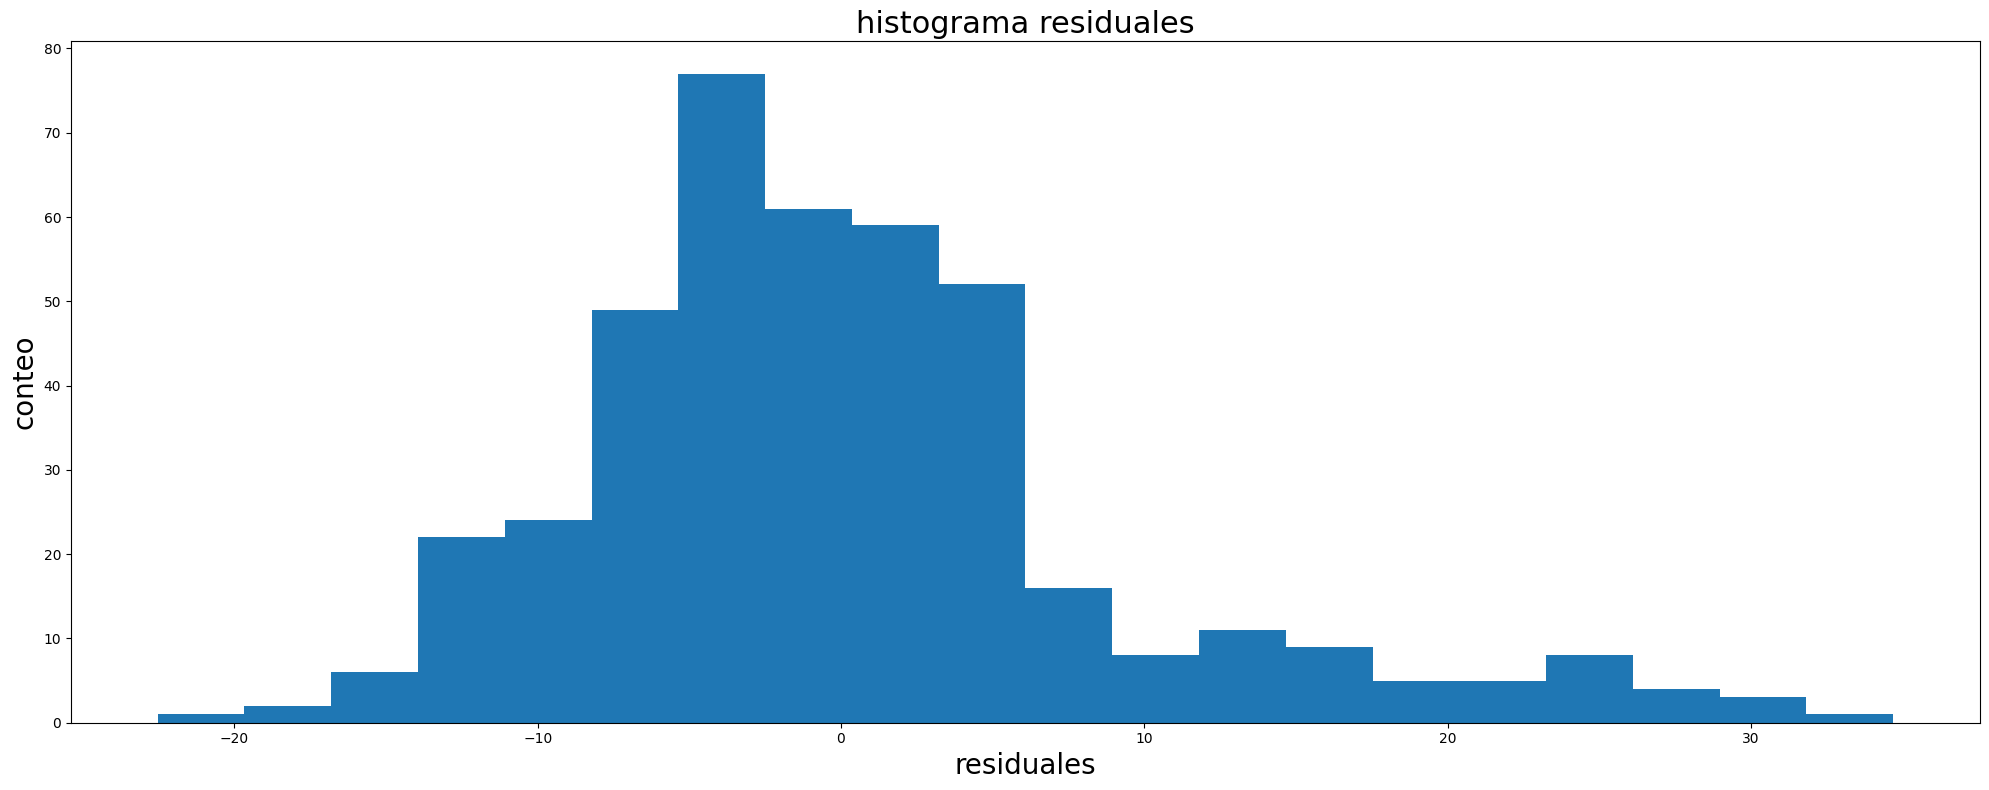

In [59]:
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(20, 8),
                        tight_layout = True)

axs.hist(errors, bins = 20)

# Specify graph features:
axs.set_title('histograma residuales', fontsize=22)
axs.set_ylabel('conteo', fontsize=20)
axs.set_xlabel('residuales', fontsize=20)

# Show plot
plt.show()

Text(0, 0.5, 'ACF')

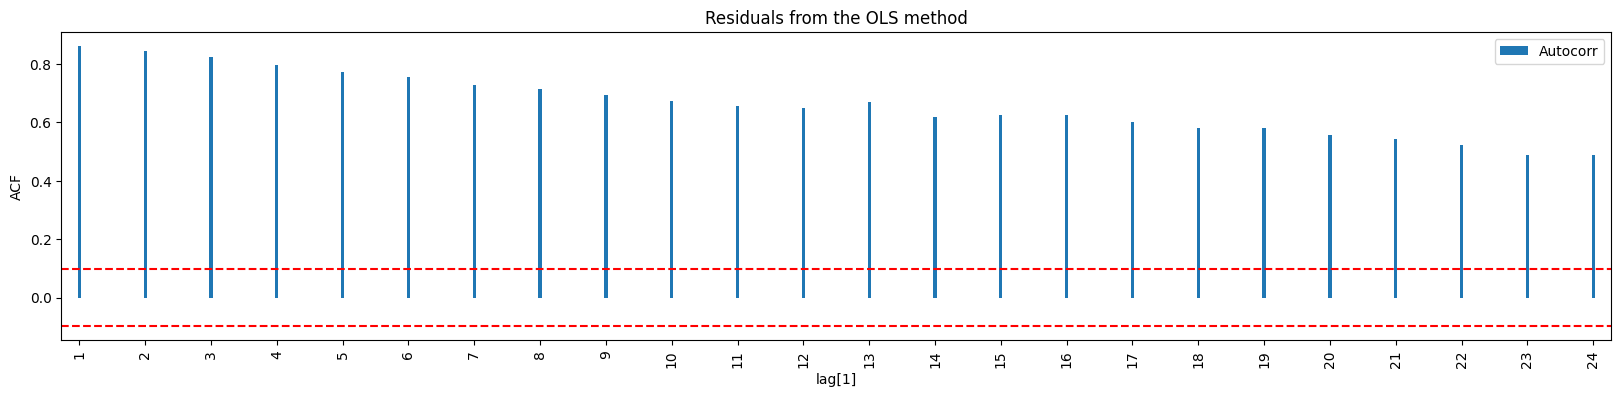

In [60]:
import math

ticker_data = errors
ticker_data_acf = [ticker_data.autocorr(i) for i in range(1,25)]

test_df = pd.DataFrame([ticker_data_acf]).T
test_df.columns = ['Autocorr']
test_df.index += 1
test_df.plot(kind='bar', width = 0.05, figsize = (20, 4))

# Statisfical significance.
n = len(errors)
plt.axhline(y = 2/math.sqrt(n), color = 'r', linestyle = 'dashed')
plt.axhline(y = -2/math.sqrt(n), color = 'r', linestyle = 'dashed')

# Adding plot title.
plt.title("Residuals from the OLS method")

# Providing x-axis name.
plt.xlabel("lag[1]")

# Providing y-axis name.
plt.ylabel("ACF")

### Fourier

In [61]:
from statsmodels.tsa.deterministic import Fourier

In [62]:
fourier_gen = Fourier(12, order=4)
fourier_data = fourier_gen.in_sample(data.index)

<Axes: xlabel='Date'>

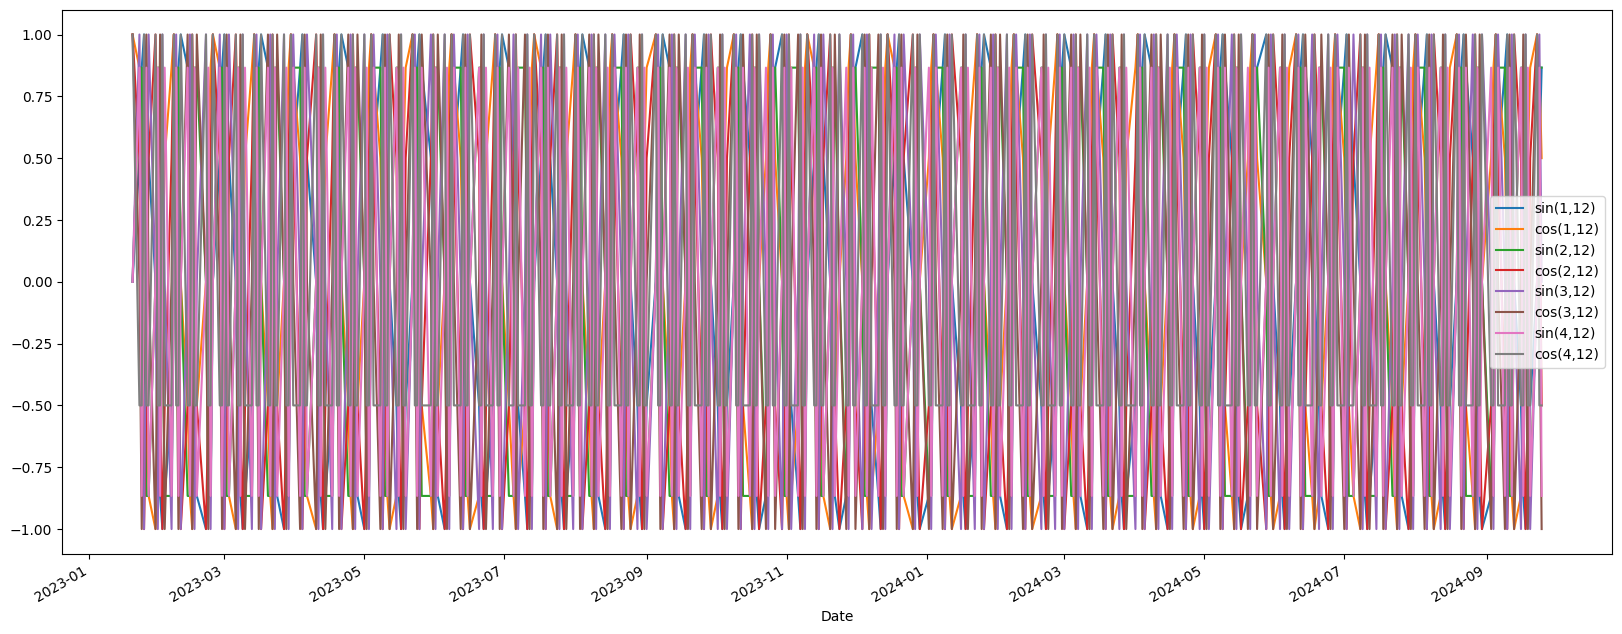

In [63]:
fourier_data.plot(figsize=(20, 8))

<Axes: xlabel='Date'>

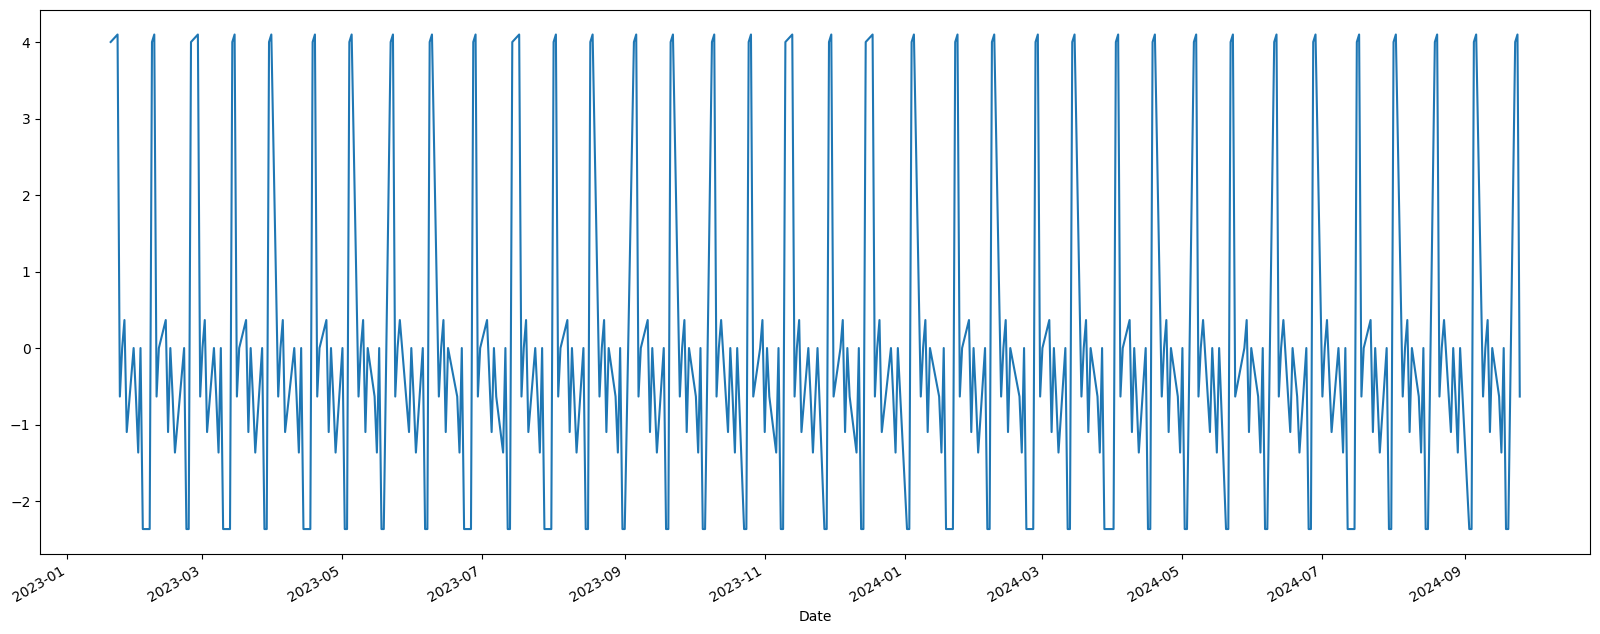

In [64]:
fourier_data.sum(1).plot(figsize=(20, 8))

In [65]:
data = data.join(fourier_data)

In [66]:
data.columns

Index(['Y', 'Close', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September',
       '2008_outlier', '2020_outlier', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'sin(1,12)',
       'cos(1,12)', 'sin(2,12)', 'cos(2,12)', 'sin(3,12)', 'cos(3,12)',
       'sin(4,12)', 'cos(4,12)'],
      dtype='object')

In [67]:
LinearRegression().fit(data.drop(columns=['Y']),
                       data['Y']).score(data.drop(
                                        columns=['Y']),
                                        data['Y'])

0.9951711563411368

In [68]:
predict = LinearRegression().fit(data.drop(columns=['Y']),
                                data['Y']).predict(data.drop(
                                            columns=['Y']))

In [69]:
errors = predict - data['Y']

In [70]:
predict = pd.Series(predict, index=errors.index)

### accuracy measures and fit

In [71]:
training_mask = data.index > '2022-01-01'
test = data[training_mask]
train = data[~training_mask]

In [72]:
test.shape, train.shape

((423, 35), (0, 35))

In [73]:
errors.sum()

-2.19912976717751e-12

In [74]:
errors.mean()

-5.198888338481111e-15

In [75]:
mae = np.mean(abs(errors))
mae

1.5598412050014743

In [76]:
rmse = np.sqrt(np.mean(errors**2))
rmse

2.3738561010788004

In [77]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(data['Y'], predict)
mape

0.024693791768365534

<Axes: xlabel='Date'>

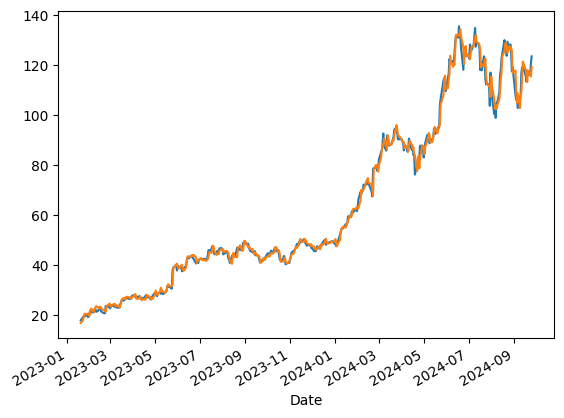

In [78]:
data['Y'].plot()
predict.plot()

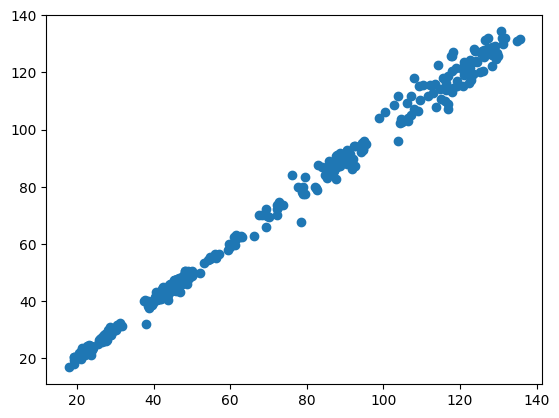

In [79]:
plt.scatter(data['Y'], predict)

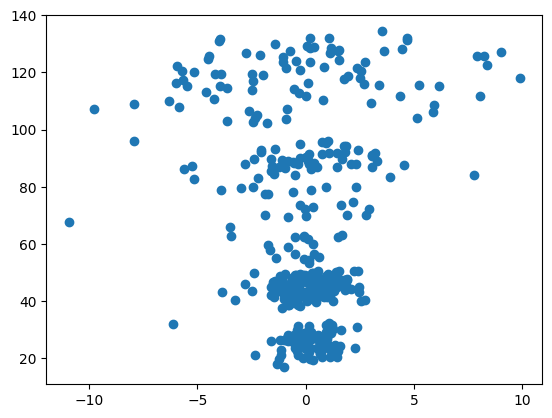

In [80]:
plt.scatter(x=errors, y=predict)

## Selección de predictores

Where possible, all potential regression models should be fitted (as was done in the example above) and the best model should be selected based on one of the measures discussed. This is known as “best subsets” regression or “all possible subsets” regression.


### Stepwise

If there are a large number of predictors, it is not possible to fit all possible models. For example, 40 predictors leads to 2^40 > 1 trillion possible models! Consequently, a strategy is required to limit the number of models to be explored.

An approach that works quite well is backwards stepwise regression:

Start with the model containing all potential predictors.
- Remove one predictor at a time.
- Keep the model if it improves the measure of predictive accuracy.
- Iterate until no further improvement.

If the number of potential predictors is too large, then the backwards stepwise regression will not work and forward stepwise regression can be used instead. This procedure starts with a model that includes only the intercept. Predictors are added one at a time, and the one that most improves the measure of predictive accuracy is retained in the model. The procedure is repeated until no further improvement can be achieved.

### Regularization

### `Background:`

`Linear Regression` has a few problems that we should address:

+ **`Predictions:`** Linear Regression will often have (*Low Bias & High Variance*).
    * When you are trying to improve `predicted accuracy` changing the bias in order to lower variance.

+ **`Interpretation:`** Linear Regression, also assigns a coefficient for each predictor.
    * But, what do we do when we have large number of variables out weighing number of observations?
        * You may need to for go getting rid of some variables in order to simplify interpretation and complexity of your model.
        
`When we think about Linear Regression:`

we are trying to find a relationship between the predictors ( $x_1,x_2,...x_{n-1}$ ) and the response 'dependent' variable ( $y$ )

`True Model:` <font size=4>$y= \beta_o +\beta_1 x_1+\beta_2 x_2+...\beta_{k-1} x_{k-1} +\varepsilon$</font>

`Estimated Model:`<font size=4>$\hat y=\hat\beta_o +\hat\beta_1 x_1+\hat\beta_2 x_2+...\hat\beta_{k} x_{k}$</font>

where <font size=4>$\varepsilon$</font> is our error

<font size=4>$\beta_1...\beta_{n-1}$</font>, parameters we need to find

<font size=4>$\beta_o$</font>, intercept

And `we want to find the best value of` <font size=4>$\beta$</font> this is done by finding the optimal <font size=4>$\beta$</font> `which minimizes` the ` Sum of Squared Errors (SSE)`

`Since this is Linear Regression we will show:`

<font size=4>$\varepsilon_i = y_i -y_{predicted}$</font>

`which becomes`

<font size=4>$\varepsilon_1^2 +\varepsilon_2^2+\varepsilon_3^2...\varepsilon_n^2 =$</font> (Residual Sum of Squares)

`and therefore,` <font size=4>$RSS= (Y_1-\beta_o-\beta_1X_1)^2+(Y_2-\beta_o-\beta_1X_2)^2+...+(Y_n-\beta_o-\beta_1X_n)^2$</font>

`simplified version: this is what we are trying to minimize!`

<font size=4>$RSS = \sum\limits_{i=1}^n (Y_n-\beta_o-\beta_1X_n)^2$</font>

`This is the sum of the true (y) and the predicted values`

# `There are 4 Assumptions of Linear Regression: `

**1. ) Linear Relationship:** the independent and dependent variables have a linear relationship
    * examine using a scatter plot of x,y

**2. ) Independence:** there is NOT correlation 'relationship' between residuals and the Y variable (you want (Y) to be independent!)
    * use a scatter plot of residuals vs fits

**3. ) Homoscedastic:** 'constant variance', variance of residuals should return the same values for all values of X.
    * check using a scatter plot of residuals vs fit and look to see if there seems to be a relationship or pattern because there should NOT.

**4. ) Normality of Residuals:** should be approximately normal.
    * you can use a histogram of the residuals to see if this is the case
    
[cite](https://online.stat.psu.edu/stat500/lesson/9/9.2/9.2.3)

`---------------------------`

`----------------------`

# `Overfitting:`

Is a problem because it doesn't allow you to generalize your model. Instead you are actually modeling the current dataset. Your model will fail when new observations are used for prediction.

`High Bias: Underfitting!`, clearly missing the relationships that occur
    + Consistent but inaccurate for training on average
    
`High variance: OverFitting`, you are taking into account random noise that is irrelevant
    + accuarate on average but inconsistent

`------------------------------`

`Side Note:` understand that OLS, doesn't care which independent variables are important. You are only finding the unbiased coefficients.
+ This should bring us to a question: does the model with lowest RSS, provide best results?
    + Short answer: NOPE, because of overfitting

# `Bias-Variance Tradeoff:`


**`Bias:`** `measure of how far an estimate is from the true value`

**`Variance:`** think of it as the reciprical of precision. Also, it is the spread of our data. Essentially, the variability for some prediction of our data point of interest.

`brief explanation with examples:`

+ `Low Variance algorithms:` will be less complex and more rigid
    * Regression
    * Naive Bayes
    * Parametric Algorithms
+ `Low Bias:` will be more complex but, flexible
    * Decision Trees
    * Nearest Neighbors
    * Non-linear/Non-parametric algorithms

`---------------------------`

# `We need to be careful:` Pay attention here...

Think about thise: we are interested in the `total error`

**`Total Error =`** <font size=3>$ bias^2$</font> **`+ variance + Irreducible Error`**

+ `Don't fall into` the trap of thinking that we need to `reduce/minimize bias at the expense of variance` at all cost. This can be problematic.

    + I understand that saying: well something is wrong with my model. Since I have high bias, fundamentally I need to fix this. And yes, increasing the variance will give you a more complex model and on average a better prediction. But, this is only part of the story.
        + This is due to the fact that you are trying to model your data and NOT a hypothetical situation with a long term averaging effect.

**Figure 06:** `Bias Variance Tradeoff`
<img src="/content/drive/MyDrive/series_tiempo/bias_var_trdoff.png">

[source](http://scott.fortmann-roe.com/docs/BiasVariance.html)

# `Stepping into Multiple Dimensions:`

`Brief workup for our Lasso & Ridge motivation`

`The short comings of Linear Regression need to be assessed with high dimensional data.`
For example, when you have a large amount of predictors (think columns) versus your obersvations (think rows) you will have difficulty of asserting that the columns are independent.

+ We need to step up in dimensions and go to matrices and vectors where;

<font size=4>$Y = [y_i]_n$</font>

<font size=4>$X=[x_{i,j}]_{nxk}$</font>

<font size=4>$\beta=[\beta_j]_k$</font>

<font size=4>$\varepsilon =[\varepsilon_i]_n$</font>

Now with matrices/vectors we have <font size=4>$y = X \beta +\varepsilon$</font> once again just expanded dimensions

And the error: <font size=4>$\sum\limits_{i=1}^n \varepsilon_i^2 = \varepsilon^T \varepsilon = (y-X\beta)^T(y-X\beta)$</font>

`Expand`

<font size=4>$min_{\beta} (\varepsilon^T \varepsilon) = y^Ty-2\beta^TX^Ty+\beta^TX^TX\beta$</font>

`Take Derivative:`

<font size=5>$\frac{\partial (\varepsilon^T \varepsilon)}{\partial \beta}=-2X^Ty+2X^TX\beta=0$</font>

`Rearrange to get beta:` now we have Least Squares in vector form

<font size=4>$\hat\beta=(X^TX)^{-1}X^Ty$</font>, only works if inverse exists

`-----------------------`

`Considerations:`

<font size=4>$\beta$</font> works well when the columns of X, are independent. But, when you are dealing with large number of features (columns) and low observations (rows) then you end up with X not being invertable.
+ This occurs because you are not able to invert <font size=4>$X^TX$</font> won't be linerarly independent

**We can fix some of the instablility of the** <font size=4>$X^TX$</font> **by adding a**
 <font size=4>$\lambda$</font> **to the diagonals of that matrix before taking its inverse**
That's what leads to our new Lasso, Ridge---

[example and discussion](https://www.stat.cmu.edu/~ryantibs/advmethods/notes/highdim.pdf)

`--------------------------------`

# `Ridge: L2 `

`Think of it as a squared penalty`

+ Uses a shrinkage parameter $\lambda$ for tuning.
    * $\lambda$ is used as a penalizing term.
    
+ `We are minimizing the size of the coefficients as well as the squared error`

`Starting with our OLS`
<font size=4>$RSS = \sum\limits_{i=1}^n (Y_n-\beta_o-\beta_1X_n)^2$</font>

<font size=4>$Ridge=RSS+\lambda \sum\limits_{i=1}^n\beta^2_i$</font>

`Don't worry: I got you covered with vectors too:`

<font size=4>$\hat \beta = (X^TX+\lambda I) X^TY$</font>

+ we have now added our shrinkage term. The tuning parameter <font size=4>$\lambda$</font> will be used for regression coefficients.
    + `When` <font size=4>$\lambda$</font> `is large, the coefficients` <font size=4>$\beta$</font> `approach zero`
        + `This will in turn increase bias and reduce variance`
+ On the flip side, when the <font size=4>$\lambda$</font> becomes small you will return least squares
    + `And reverse the results from above: increasing variance and reducing bias`


![](/content/drive/MyDrive/series_tiempo/ridge_plt.png)

`Notice Errors for each:`

**Figure 07:** `Ridge vs Linear Regression`
<img src="https://github.com/daniel-nuno/time_series_O2024_MAF3074N/blob/main/Ridge_plt.png?raw=1">

+ `Take away:`

1.) Increasing $\lambda$ toward infinity will create Underfitting and decrease variance

2.) The trough region is our optimal postion for bias/variance tradeoff

3.) reducing the $\lambda$ toward zero results in the OLS

4.) The errors are different: OLS is around 1.8 vs Ridge which is 1.2

+ **`Ridge: reduces complexity NOT remove features but instead shrinks their effects`**

+ **`Think of trying to find a new line that doesn't fit so great to the training data in order to create better predictions overall`**

+ `You may not have thought about this but your degrees of freedom are effectively` your shrinkage [source](https://online.stat.psu.edu/stat508/lesson/5/5.1)

`------------------------------`

**Figure 08:** `Ridge vs OLS`
<img src="https://github.com/daniel-nuno/time_series_O2024_MAF3074N/blob/main/Ridge_ols.png?raw=1">


1.) Ellipse corresponds to contours of residual sum of squares (rss). The inner ellipse has smaller (rss) and is minimized by (OLS) estimates.

2.) We are trying to minimize the size of the circle and the ellipse at the same time and we are subject to a constraint $\sum\limits^n_{i=1}\lambda<constant$
+ There is a correspondance between $\lambda$ and $c$.
    * The larger $\lambda$, the more $\beta's$ prefer zero.
    * When $\lambda=0$ then you have linear regression
    * when $\lambda$ approaches $\infty$ then $\beta's$ approaches zero.

3.) the ridge estimate is given when the point at which they touch

4.) Each contour line has the same (rss) and the lowest (rss) is at the center

5.) The (OLS) point where it best fits the `training data` set has low bias at the center!

[image cite & discussion](https://online.stat.psu.edu/stat508/lesson/5/5.1) | [cite discussion](https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db)

# `How do we actually find the optimal` <font size=6>$\lambda?$</font>

That is when we consider cross-validation.

# `Considerations:`

+ Consider scaling your features so that your coefficients are not mistaken because of their sizes. You only want to have them disregarded due to their importance remember.

# `Interpretation of coefficients:`

+ You are interested in predictions <font size=4>$\hat y$</font>. This is not an inference problem where we would evaluate <font size=4>$\hat\beta$</font>

+ We have to think about the fact that variables may be correlated with other variables.


# `Lasso: feature selection, L1 error`

`Think of it as an absolute value penalty`

<font size=4>$Lasso=RSS+\lambda \sum\limits_{i=1}^n||\beta_i||$</font>

`L1:`causes the coefficients to be shrunken to exactly zero. As $\lambda$ increases more coefficients will go to zero and less predictors are selected.


+ `Downside:` NOT strickly convex.
    + What does this mean?
        * If we had let's say 2 features that were identical then we wouldn't be able to distinguish them when trying to minimize. In such an instance, we would consider `Elastic Net`.
            * Elastic Net, would give us a unique solution in that circumstance
  

**Figure 09:** `Lasso vs OLS`
<img src="https://github.com/daniel-nuno/time_series_O2024_MAF3074N/blob/main/lasso_ols.png?raw=1">


There is a slight difference now with the diamond shape.
+ We are able to do feature selection. When the tip of the diamond reaches the edge of the (OLS) then the coefficient corresponding to the axis will be shrunk to zero.
    + Notice this is 2D, if we increase the dimensions we will increase the amount of diamonds and therefore corners which will in turn give us the ability to have more coefficients shrunk to zero potentially.

[image source](https://medium.com/@zxr.nju/the-classical-linear-regression-model-is-good-why-do-we-need-regularization-c89dba10c8eb)

**Figure 10:** `Lasso vs Ridge [DF,Error]`
<img src="https://github.com/daniel-nuno/time_series_O2024_MAF3074N/blob/main/lasso_ridge_compare.png?raw=1">

+ Take away: the errors are close but...
    + `Ridge` will always have all parameters no matter what
    + `Lasso` on average it will keep 24 parameters


[image_source](https://www.stat.cmu.edu/~ryantibs/advmethods/notes/highdim.pdf)

**Figure 11:** `MSE vs Lambda`
<img src="https://github.com/daniel-nuno/time_series_O2024_MAF3074N/blob/main/ridge_mse_comp.png?raw=1">

`Notice:`
1.) The when $\lambda$ is really small (going left), you are essentially using OLS for training the model.
+ At this point the error is low for training but, quite high for test data.
    + This suggests overfitting as you increase $\lambda$
        + Need to simplify your model
        
2.) When you reach the low spot for testing area, the concave portion: we reached the sweet spot of interest (Low variance and Low bias).
+ If you keep moving to greater $\lambda$ after this point you will start to under fit


[image_source](https://bookdown.org/tpinto_home/Regularisation/lasso-regression.html)

### ` Ridge & Lasso Plotted for comparison:`

**Figure 12:** `Lasso (Right) vs Ridge Example comparison`
<img src="https://github.com/daniel-nuno/time_series_O2024_MAF3074N/blob/main/lasso_ridge_ex_comp.png?raw=1">

1.) `Ridge` will approach zero but not achieve it

2.) `Lasso` will get to exactly zero for some variables

3.) notice the negative green line for possible correlation

4.) lcp, age, gleason not important and set to zero

[source image](https://www.csd.uoc.gr/~hy590-21/pdfs/lab_linear_regression_hy539.pdf)

![](https://drive.google.com/content/drive/MyDrive/series_tiempo/lasso_ridge_compare.png)

### Ridge Code

In [81]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [82]:
Ridge(alpha=1.0).fit(data.drop(columns=['Y']), data['Y']).score(data.drop(columns=['Y']), data['Y'])

0.9951697921725945

In [83]:
predict = Ridge(alpha=1.0).fit(data.drop(columns=['Y']), data['Y']).predict(data.drop(columns=['Y']))

In [84]:
Ridge(alpha=1.0).fit(data.drop(columns=['Y']), data['Y']).feature_names_in_

array(['Close', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September',
       '2008_outlier', '2020_outlier', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
       'sin(1,12)', 'cos(1,12)', 'sin(2,12)', 'cos(2,12)', 'sin(3,12)',
       'cos(3,12)', 'sin(4,12)', 'cos(4,12)'], dtype=object)

In [85]:
Ridge(alpha=1.0).fit(data.drop(columns=['Y']), data['Y']).coef_

array([ 0.0039316 ,  0.17600168,  0.15563209,  0.8732494 ,  0.69524302,
       -0.1399679 ,  0.88467768,  0.5911407 ,  0.93589968,  0.49438039,
       -0.02937331, -0.14150231,  0.        ,  0.        ,  0.86930991,
        0.19812503, -0.09589269,  0.06325594, -0.1406919 ,  0.0941658 ,
        0.00874097,  0.0197747 ,  0.05048532, -0.2289888 ,  0.02286004,
        0.14079281,  0.29314778, -0.12444283, -0.20624409, -0.22041526,
       -0.25603444, -0.13034902,  0.10043605, -0.09811543])

In [86]:
from sklearn.linear_model import RidgeCV

In [87]:
ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(data.drop(columns=['Y']), data['Y'])
ridge_cv.score(data.drop(columns=['Y']), data['Y'])

0.9950721051054611

In [89]:
ridge_cv.alpha_

100.0

In [88]:
ridge_cv.best_score_

-6.841269066228269

### Lasso

In [90]:
from sklearn.linear_model import Lasso

In [91]:
Lasso(alpha=0.1).fit(data.drop(columns=['Y']), data['Y']).score(data.drop(columns=['Y']), data['Y'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.928e+01, tolerance: 4.936e+01
  model = cd_fast.enet_coordinate_descent(


0.9949309052547164

In [92]:
Lasso(alpha=1).fit(data.drop(columns=['Y']), data['Y']).feature_names_in_

array(['Close', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September',
       '2008_outlier', '2020_outlier', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
       'sin(1,12)', 'cos(1,12)', 'sin(2,12)', 'cos(2,12)', 'sin(3,12)',
       'cos(3,12)', 'sin(4,12)', 'cos(4,12)'], dtype=object)

In [93]:
Lasso(alpha=1).fit(data.drop(columns=['Y']), data['Y']).intercept_

0.3832461305974846

In [94]:
Lasso(alpha=1).fit(data.drop(columns=['Y']), data['Y']).coef_

array([ 0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.90234993,
        0.09355705,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.002493  ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ])

In [95]:
from sklearn.linear_model import LassoCV

In [96]:
lasso_cv = LassoCV(cv=5, random_state=0).fit(data.drop(columns=['Y']), data['Y'])
lasso_cv.score(data.drop(columns=['Y']), data['Y'])

0.9946388092606961

In [97]:
lasso_cv.alpha_

2.8787500363183507

In [98]:
lasso_cv.coef_

array([ 0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.90196452,
        0.0933713 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00140945,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ])